In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split

from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)

import statsmodels.tsa.api as tsa

#set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)

# set random seed
SEED = 321
np.random.seed(SEED)

# Part 1

In [ ]:
# Load the provided csv.
covid_df = pd.read_csv('/content/drive/MyDrive/datasets/us-covid-confirmed.csv')

In [ ]:
covid_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,24012023,25012023,26012023,27012023,28012023,29012023,30012023,31012023,01022023,02022023
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,19389,19471,19471,19471,19471,19471,19471,19471,19530,19530
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,68764,68983,68983,68983,68983,68983,68983,68983,69187,69187
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,7258,7299,7299,7299,7299,7299,7299,7299,7339,7339
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,7889,7919,7919,7919,7919,7919,7919,7919,7967,7967
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,18130,18255,18255,18255,18255,18255,18255,18255,18349,18349


In [ ]:
# Prepare the data as a time series DataFrame:

# Melt the wide-form data into a long-form time series.

covid_df = pd.melt(covid_df, id_vars=[
    'UID',
    'iso2',
    'iso3',
    'code3',
    'FIPS',
    'Admin2',
    'Province_State',
    'Country_Region',
    'Lat',
    'Long_',
    'Combined_Key'
  ], var_name='Date', value_name='Confirmed')


In [ ]:
covid_df.loc[(covid_df['UID']==84001001)&(covid_df['date']==28012023)]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,date,covid_cases
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",22012020,0
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",22012020,0
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",22012020,0
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",22012020,0
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",22012020,0


In [ ]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3702936 entries, 0 to 3702935
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   UID             int64  
 1   iso2            object 
 2   iso3            object 
 3   code3           int64  
 4   FIPS            float64
 5   Admin2          object 
 6   Province_State  object 
 7   Country_Region  object 
 8   Lat             float64
 9   Long_           float64
 10  Combined_Key    object 
 11  date            object 
 12  covid_cases     int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 367.3+ MB


In [ ]:
covid_df.loc[(covid_df['UID']==84001001)&(covid_df['date']=='28012023')]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,date,covid_cases
3682884,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",28012023,19471


In [ ]:
# Convert the Date column to a Datetime index.
# Use the format argument, format = "%d%m%Y"
covid_df['Date'] = pd.to_datetime(covid_df['Date'], format='%d%m%Y')

# Set the Date column as the index
covid_df = covid_df.set_index('Date')

In [ ]:
covid_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Confirmed
Date,,,,,,,,,,,,
2020-01-22,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0
2020-01-22,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0
2020-01-22,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0
2020-01-22,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0
2020-01-22,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0


In [ ]:
covid_df.index

DatetimeIndex(['2020-01-22', '2020-01-22', '2020-01-22', '2020-01-22',
               '2020-01-22', '2020-01-22', '2020-01-22', '2020-01-22',
               '2020-01-22', '2020-01-22',
               ...
               '2023-02-02', '2023-02-02', '2023-02-02', '2023-02-02',
               '2023-02-02', '2023-02-02', '2023-02-02', '2023-02-02',
               '2023-02-02', '2023-02-02'],
              dtype='datetime64[ns]', name='Date', length=3702936, freq=None)

In [ ]:
# Filter the data:
# Keep data from the following states:
#'New York', "New Jersey", "Pennsylvania", 'Delaware', 'Rhode Island', 'Maryland', "Virginia", "North Carolina"
# Keep all data from 05/2020 to the present.

covid_filtered_df = covid_df.loc[
    covid_df['Province_State'].isin(['New York', "New Jersey", "Pennsylvania", 'Delaware', 'Rhode Island', 'Maryland', "Virginia", "North Carolina"])
].loc['2020-05':]

In [ ]:
covid_filtered_df.index

DatetimeIndex(['2020-05-01', '2020-05-01', '2020-05-01', '2020-05-01',
               '2020-05-01', '2020-05-01', '2020-05-01', '2020-05-01',
               '2020-05-01', '2020-05-01',
               ...
               '2023-02-02', '2023-02-02', '2023-02-02', '2023-02-02',
               '2023-02-02', '2023-02-02', '2023-02-02', '2023-02-02',
               '2023-02-02', '2023-02-02'],
              dtype='datetime64[ns]', name='Date', length=434448, freq=None)

In [ ]:
# Save the processed data as a .csv file in a “Data” folder inside your private repo, name the csv “Data/data-for-tableau.csv”
covid_filtered_df.to_csv('/content/drive/MyDrive/datasets/data-for-tableau.csv')

In [ ]:
# Resample the cases, grouped by states, as daily frequency using sum as the aggregate function.
covid_filtered_df = covid_filtered_df.resample('D')

In [ ]:
covid_filtered_ts = covid_filtered_df.groupby('Province_State').resample('D')['Confirmed'].sum()

In [ ]:
covid_filtered_ts = covid_filtered_ts.reset_index().set_index('Date')

In [ ]:
covid_filtered_ts

,Province_State,Confirmed
Date,,
2020-05-01,Delaware,4918
2020-05-02,Delaware,5038
2020-05-03,Delaware,5208
2020-05-04,Delaware,5288
2020-05-05,Delaware,5371
...,...,...
2023-01-29,Virginia,2251042
2023-01-30,Virginia,2251042
2023-01-31,Virginia,2260796


Province_State
Delaware          Axes(0.125,0.11;0.775x0.77)
Maryland          Axes(0.125,0.11;0.775x0.77)
New Jersey        Axes(0.125,0.11;0.775x0.77)
New York          Axes(0.125,0.11;0.775x0.77)
North Carolina    Axes(0.125,0.11;0.775x0.77)
Pennsylvania      Axes(0.125,0.11;0.775x0.77)
Rhode Island      Axes(0.125,0.11;0.775x0.77)
Virginia          Axes(0.125,0.11;0.775x0.77)
Name: Confirmed, dtype: object

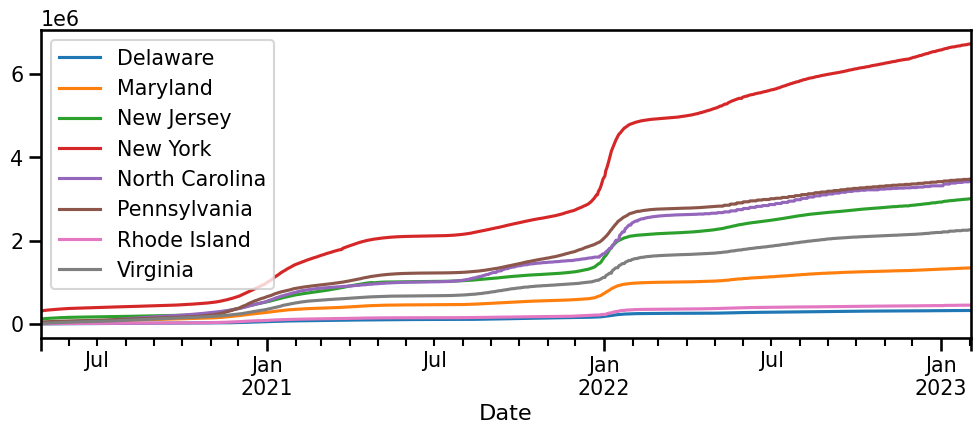

In [ ]:
# Plot a line graph with each state's Confirmed cases as a separate line.
covid_filtered_ts.groupby('Province_State')['Confirmed'].plot(legend=True)

# Part 2

In [ ]:
# Filter the data and transform the data to obtain a time series of the cases count by week.
# New York
# Resample to weekly counts using .last() to get the cumulative count on the last day of the week
# After resampling, filter to keep dates from 05/2020 through 01/2023.
covid_filtered_ts = covid_filtered_ts.loc[covid_filtered_ts['Province_State']=='New York'].resample('W')
covid_filtered_ts

AttributeError: 'DatetimeIndexResampler' object has no attribute 'loc'

In [ ]:
covid_filtered_ts = covid_filtered_ts.last()

In [ ]:
covid_filtered_ts = covid_filtered_ts['Confirmed']

In [ ]:
# Check for and address null values.
covid_filtered_ts.isna().sum()

Province_State    0
Confirmed         0
dtype: int64

In [ ]:
# Decompose the Time series to detect seasonality and decide whether to use a seasonal model or not
sd = tsa.seasonal_decompose(covid_filtered_ts)

In [ ]:
covid_filtered_ts

Date
2020-05-03     320685
2020-05-10     339202
2020-05-17     353002
2020-05-24     364697
2020-05-31     373682
               ...   
2023-01-08    6615741
2023-01-15    6649934
2023-01-22    6675480
2023-01-29    6702694
2023-02-05    6721124
Freq: W-SUN, Name: Confirmed, Length: 145, dtype: int64

AttributeError: 'Figure' object has no attribute 'tight_layoutht_layout'

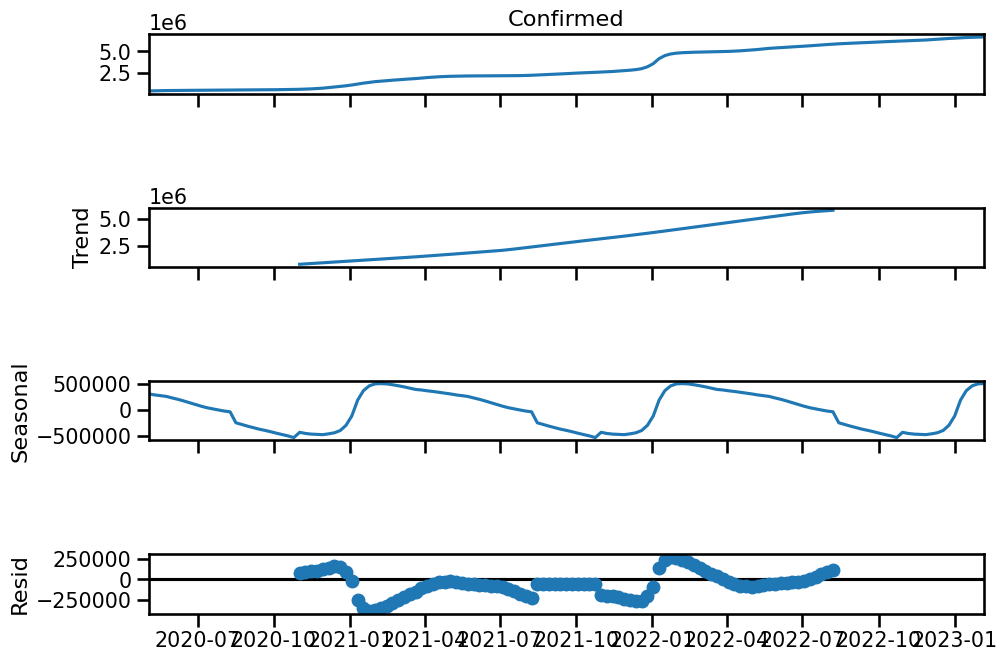

In [ ]:
fig = sd.plot()
fig.set_size_inches(10,8)
fig.tight_layoutht_layout()


Use the ACF and PACF plots of stationarity data to estimate initial orders
Split the time series into training and test data (Remember we want to predict 4 weeks)
(You may get warnings when fitting models, but that is okay.)






